# I. Introduction


Nama : Samuel Kristianto Pardomuan Naiborhu

Batch : FTDS-015

Dataset : apple2orange-dataset

Objective : To detect whether the image we input is apple or orange

# Download Dataset straight from kaggle

In [23]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 

!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

mkdir: cannot create directory ‘./kaggle’: File exists


In [24]:
!chmod 600 ~/.kaggle/kaggle.json # authorization with json
!ls ~/.kaggle # data list checking

kaggle.json


In [25]:
# download datasets
!kaggle datasets download -d balraj98/apple2orange-dataset

apple2orange-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
# !unzip -q /content/apple2orange-dataset.zip -d dataset
!unzip -q /content/apple2orange-dataset.zip -d images

replace images/metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/testA/n07740461_10011.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#  II. Import Library

In [46]:
# import library
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

import numpy as np

from PIL import Image
from google.colab import files

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Define main directory
main_path= '/content/images'

In [29]:
# Define apple directory
trainA_dir = os.path.join(main_path, 'trainA')
testA_dir = os.path.join(main_path, 'testA')

# Define orange directory
trainB_dir = os.path.join(main_path, 'trainB')
testB_dir = os.path.join(main_path, 'testB')

In [30]:
# check trainA(apple) directory
trainA_dir

'/content/images/trainA'

#  III. EDA

In [31]:
# check train set counts
print('train set: \n' + '='*50)
num_apple= len(os.listdir(os.path.join(trainA_dir)))
num_orange= len(os.listdir(os.path.join(trainB_dir)))
print(f'count apple= {num_apple}')
print(f'count orange= {num_orange}')

train set: 
count apple= 995
count orange= 1019


The training set has 995 apple images and 1019 orange images, in total the dataset that we're goint to train is 2014.

In [32]:
# check test set counts
print('test set: \n' + '='*50)
num_apple= len(os.listdir(os.path.join(testA_dir)))
num_orange= len(os.listdir(os.path.join(testB_dir)))
print(f'count apple= {num_apple}')
print(f'count orange= {num_orange}')

test set: 
count apple= 266
count orange= 248


The test set has 266 apple images and 248 orange images, in total the test dataset has 514

In [33]:
# define apple and orange images in training set
train_apple = glob.glob(trainA_dir + "/*.jpg")
train_orange = glob.glob(trainB_dir+ "/*.jpg")

# define apple and orange images in test set
test_apple = glob.glob(testA_dir+ "/*.jpg")
test_orange = glob.glob(testB_dir+ "/*.jpg")

In [34]:
# Create function to create dataframe
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

#create dataframe for training set
train_df = create_dataframe(train_apple + train_orange)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

#create dataframe for test set
test_df = create_dataframe(test_apple + test_orange)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [35]:
# summarize train dataframe
print(train_df.shape)
train_df.head()

(2014, 2)


,images,label
0,/content/images/trainA/n07740461_14824.jpg,trainA
1,/content/images/trainA/n07740461_7184.jpg,trainA
2,/content/images/trainA/n07740461_12837.jpg,trainA
3,/content/images/trainA/n07740461_8978.jpg,trainA
4,/content/images/trainA/n07740461_1849.jpg,trainA


In [36]:
# summarize test dataframe
print(test_df.shape)
test_df.head()

(514, 2)


,images,label
0,/content/images/testA/n07740461_1780.jpg,testA
1,/content/images/testB/n07749192_5881.jpg,testB
2,/content/images/testB/n07749192_2610.jpg,testB
3,/content/images/testA/n07740461_230.jpg,testA
4,/content/images/testB/n07749192_1161.jpg,testB


In [37]:
# split dataset
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(1611, 2)
(403, 2)


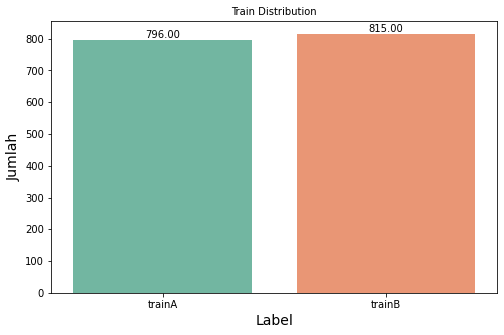

In [38]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

- trainA = apple
- trainB = orange

Both apple and orange class counts are relatively balanced, with apple have 796 data, while orange have 815 data. Seems like the data have been prepared by the uploader. If we want to make models from this dataset, the results wouldnt be bias to one side.

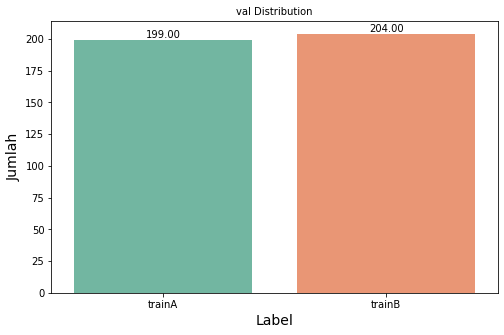

In [39]:
visualize_data(val_df, 'val')

- trainA = apple
- trainB = orange

Both apple and orange class counts are relatively balanced, with apple have 199 data, while orange have 204 data. These are the validation data thouh, it wont influence the model results.

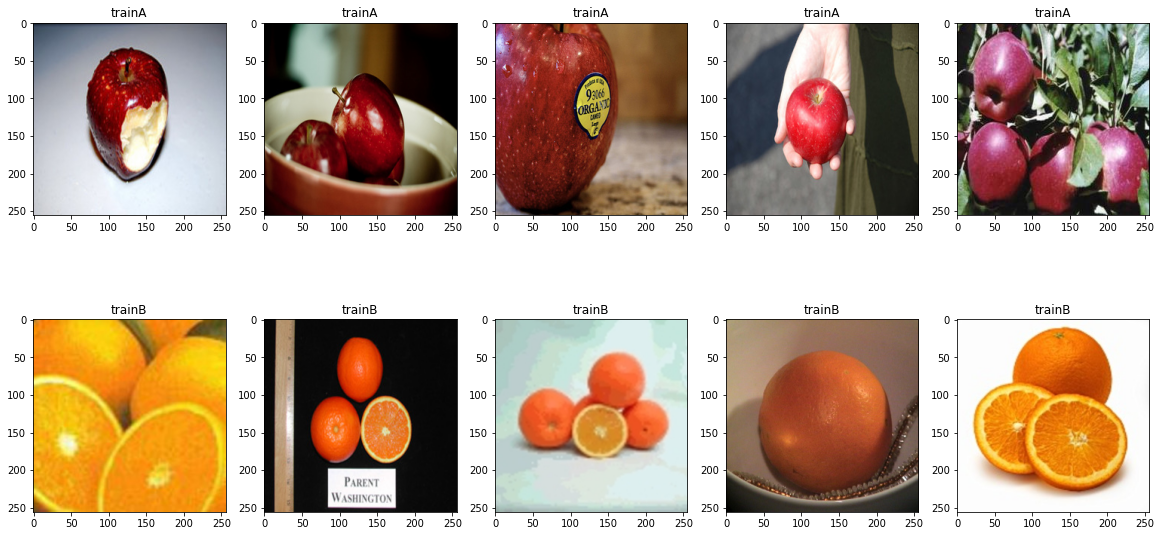

In [40]:
# Get few samples for both the classes
apple_samples = (train_df[train_df['label']=="trainA"]['images'].iloc[:5]).tolist()
orange_samples = (train_df[train_df['label']=='trainB']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(apple_samples + orange_samples)

From the samples above, we can see from the color themselves there are some differences from both apple and orange. If both fruits get peeled, the difference is even more stark, inside apple its white, while orange is orange, therefore Making a model to predict which is orange or apple, is relatively easy, especially with that much data.

# IV. Data Augmentation

In [ ]:
# setting up the image for data augmentation
img_height= 256
img_width= 256
SEED = 1
BATCH =64

In [ ]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, # pixel scaling
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255) # rescale = pixel scaling
test_datagen = ImageDataGenerator(rescale=1./255) # rescale = pixel scaling

In [ ]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 1611 validated image filenames belonging to 2 classes.
Found 403 validated image filenames belonging to 2 classes.
Found 514 validated image filenames belonging to 2 classes.


In [ ]:
# check the label from the dataset
ds_train.class_indices

{'trainA': 0, 'trainB': 1}

# V. Modeling

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
    #ReduceLROnPlateau
]

In [ ]:
inputs= [img_height,img_width,3]

# Define model using sequential api
model= Sequential()
model.add(Conv2D(filters=16, kernel_size=3, 
                            activation= 'relu', input_shape= inputs
                            ))
model.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model.add(Conv2D(filters=32, kernel_size=3, 
                            activation= 'relu'
                            # padding='same'
                            ))
model.add(MaxPooling2D(pool_size=2, strides=2, 
                                  # padding="same"
                                  ))

#Conv 3
model.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())
model.add(Dense(units= 128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal is just to get a quick review for a base model.

In [ ]:
# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

For the model itself there are over 7 million parameter.

In [ ]:
# compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
# run model, save the history for evaluation
history= model.fit(ds_train, batch_size= BATCH, 
                           epochs= 20, validation_data= ds_val,
                           callbacks= callbacks1)

Epoch 1/20
26/26 [==============================] - 36s 1s/step - loss: 0.7365 - accuracy: 0.7045 - val_loss: 0.2954 - val_accuracy: 0.8908
Epoch 2/20
26/26 [==============================] - 24s 930ms/step - loss: 0.2742 - accuracy: 0.9025 - val_loss: 0.2446 - val_accuracy: 0.8883
Epoch 3/20
26/26 [==============================] - 24s 927ms/step - loss: 0.2223 - accuracy: 0.9261 - val_loss: 0.2038 - val_accuracy: 0.9082
Epoch 4/20
26/26 [==============================] - 23s 918ms/step - loss: 0.2138 - accuracy: 0.9137 - val_loss: 0.2551 - val_accuracy: 0.8958
Epoch 5/20
26/26 [==============================] - 23s 892ms/step - loss: 0.1704 - accuracy: 0.9336 - val_loss: 0.1637 - val_accuracy: 0.9256
Epoch 6/20
26/26 [==============================] - 23s 901ms/step - loss: 0.1995 - accuracy: 0.9193 - val_loss: 0.1571 - val_accuracy: 0.9479
Epoch 7/20
26/26 [==============================] - 23s 886ms/step - loss: 0.1563 - accuracy: 0.9417 - val_loss: 0.1992 - val_accuracy: 0.9256
Ep

# VI. Evaluation

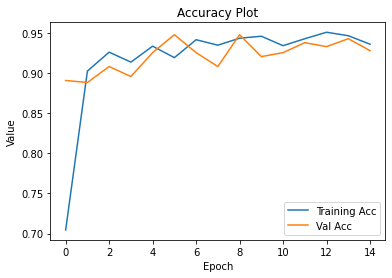

In [ ]:
# plotting model results per epoch
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

The model is very good, with each additional epoch the accuracy increases. Both the training and val accuracy are intertwined we can accept that this model is not overfit (good on training, bad on validation or test).

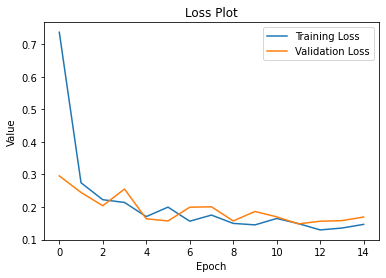

In [ ]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

With each additional epoch the loss decreases. Both the training and val acc are intertwined we can accept that this model is not overfit (good on training, bad on validation or test).

In [ ]:
# model loss and accuracy on training set
train_results = model.evaluate(ds_train, verbose=0)
print(f'Train Loss     : {train_results[0]:.4f}')
print(f'Train Accuracy : {train_results[1]:.4f}')

Train Loss     : 0.1234
Train Accuracy : 0.9553


In [ ]:
# model loss and accuracy on test set
test_results = model.evaluate(df_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.1922
Test Accuracy : 0.9300


The accuracy for the test model is quite good with a score of 0.93, although it depends on what we're going to use this model for. 

In [ ]:
y_pred_seq = model.predict(df_test)

9/9 [==============================] - 1s 139ms/step


In [ ]:
# Model Evaluation using Classification Report
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(df_test.classes, y_pred_seq))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       266
           1       0.93      0.92      0.93       248

    accuracy                           0.93       514
   macro avg       0.93      0.93      0.93       514
weighted avg       0.93      0.93      0.93       514



# VII. Model Improvements (Transfer learning)

In [ ]:
# transfer learning

# callback2
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 4), 
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
]

pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', \
                                                  input_shape=inputs, pooling='avg')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# Create the model
model_improv = Sequential()
model_improv.add(pretrained_model)
model_improv.add(Flatten())
model_improv.add(Dense(128, activation='relu'))
model_improv.add(Dense(128, activation='relu'))
model_improv.add(Dense(1, activation='sigmoid'))

For improvements modeling, rather than using convolutional, we're using transfer learning instead. And we added another hidden layer with relu.

In [ ]:
# summarize model_improv
model_improv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,140,393
Trainable params: 278,913
Non-trainable params: 20,861,480
_________________________________________________________________


For model Improvements there are over 21 million parameter.

In [ ]:
model_improv.compile(optimizer='adamax', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
# run model, save the history for evaluation
history2 = model_improv.fit(ds_train, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val,
                           callbacks= callbacks2)        

Epoch 1/10
26/26 [==============================] - 33s 1s/step - loss: 0.2157 - accuracy: 0.9174 - val_loss: 0.1230 - val_accuracy: 0.9603
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.0835 - accuracy: 0.9708 - val_loss: 0.1252 - val_accuracy: 0.9603
Epoch 3/10
26/26 [==============================] - 27s 1s/step - loss: 0.0726 - accuracy: 0.9714 - val_loss: 0.1291 - val_accuracy: 0.9628
Epoch 4/10
26/26 [==============================] - 29s 1s/step - loss: 0.0755 - accuracy: 0.9714 - val_loss: 0.1391 - val_accuracy: 0.9479
Epoch 5/10
26/26 [==============================] - 32s 1s/step - loss: 0.0676 - accuracy: 0.9777 - val_loss: 0.1222 - val_accuracy: 0.9653
Epoch 6/10
26/26 [==============================] - 27s 1s/step - loss: 0.0634 - accuracy: 0.9832 - val_loss: 0.1229 - val_accuracy: 0.9677
Epoch 7/10
26/26 [==============================] - 28s 1s/step - loss: 0.0645 - accuracy: 0.9752 - val_loss: 0.1167 - val_accuracy: 0.9603
Epoch 8/10
26/26 [==

In [ ]:
# model loss and accuracy on test set
test_results = model_improv.evaluate(df_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.1238
Test Accuracy : 0.9630


In [ ]:
# Model Evaluation using Classification Report
y_pred_seq = model_improv.predict(df_test)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(df_test.classes, y_pred_seq))


9/9 [==============================] - 4s 365ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       266
           1       0.97      0.96      0.96       248

    accuracy                           0.96       514
   macro avg       0.96      0.96      0.96       514
weighted avg       0.96      0.96      0.96       514



## Model analysis


The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal is just to get a quick review for a base model. The accuracy for the base model is quite good with a score of 0.93 on the test set, although it depends on what we're going to use this model for. 

Before improvements we get a test accuracy of 0.93, after improvements we get 0.963, this is actually really good, because the closer a model accuracy near 1.00, the harder and smaller the improvements being made. With accuracy of 0.963. 

## Model Saving

In [ ]:
# freeze model
model_improv.trainable = False

In [ ]:
# Model saving with folder so we can pass it using tf serving
model_improv.save('cv_model')

In [ ]:
# zip the saved model
! zip -r cv_model.zip cv_model

  adding: cv_model/ (stored 0%)
  adding: cv_model/keras_metadata.pb (deflated 96%)
  adding: cv_model/variables/ (stored 0%)
  adding: cv_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: cv_model/variables/variables.index (deflated 76%)
  adding: cv_model/saved_model.pb (deflated 92%)
  adding: cv_model/assets/ (stored 0%)


In [ ]:
# saving model with hdf5, just in case the other saved model fails
model_improv.save('cv_model.hdf5')

# VIII. Inference

Saving Orangefruit.jpg to Orangefruit (1).jpg


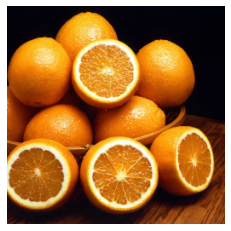

1/1 [==============================] - 0s 28ms/step
1.0
Orange


In [ ]:
uploaded = files.upload()

# looping for predicting multiple files
for fn in uploaded.keys():
 
  # prediction using images
  path = fn
  img = tf.keras.utils.load_img(
    path,
    target_size=(256,256)
)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None)
  x = np.expand_dims(x, axis=0) #expand array shape says 1D to 2D, 0 means row/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_improv.predict(images) # use improved model for prediction
  print(classes[0][0]) 
  if classes[0][0] == 0:
    print('Apple')
  else:
    print('Orange')

# IX. Conclusion

in total we have around 2568 images. We split them into 2, 1 for training and validation, and the other for testing. For model training Both apple and orange class counts are relatively balanced, with apple have 796 data, while orange have 815 data. Seems like the data have been prepared by the uploader. If we want to make models from this dataset, the results wouldnt be bias to one side.

From the data we have, we can see from the color themselves there are clear differences from both apple and orange, therefore making a model to predict which is orange or apple, is relatively easy, especially with that much data.

The accuracy from the model we've done is around 96%, which is very good. 

That said when we've done some inference on the webapp, predicting green apple is not as accurate when predicting red apple, we should add more green apple images to the datasets.